<a href="https://colab.research.google.com/github/jacob-jones23/MAT-422/blob/main/3_5_KMeans_3_6_Support_Vector_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install kneed

#**3.5 K-means**
*k*-means clustering is a popular method of vector quantization that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. k-means clustering minimizes within cluster variances (squared Euclidean distances), but not regular Euclidean distances. While k-means general converge quickly to a local optimum, the problem is computationally difficult (NP-hard).


In [8]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [9]:
features, true_labels = make_blobs(
    n_samples=200,
    centers=3,
    cluster_std=2.75,
    random_state=42
    )

In [10]:
features[:5]

array([[  9.77075874,   3.27621022],
       [ -9.71349666,  11.27451802],
       [ -6.91330582,  -9.34755911],
       [-10.86185913, -10.75063497],
       [ -8.50038027,  -4.54370383]])

In [11]:
true_labels[:5]

array([1, 0, 2, 2, 2])

In [12]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [13]:
scaled_features[:5]

array([[ 2.13082109,  0.25604351],
       [-1.52698523,  1.41036744],
       [-1.00130152, -1.56583175],
       [-1.74256891, -1.76832509],
       [-1.29924521, -0.87253446]])

In [14]:
kmeans = KMeans(
    init = "random",
    n_clusters = 3,
    n_init = 10,
    max_iter = 300,
    random_state = 42
)

In [15]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [16]:
kmeans.inertia_

74.57960106819854

In [17]:
kmeans.cluster_centers_

array([[-0.25813925,  1.05589975],
       [-0.91941183, -1.18551732],
       [ 1.19539276,  0.13158148]])

In [18]:
kmeans.n_iter_

2

In [19]:
kmeans.labels_[:5]

array([2, 0, 1, 1, 1], dtype=int32)

In [20]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  sse.append(kmeans.inertia_)

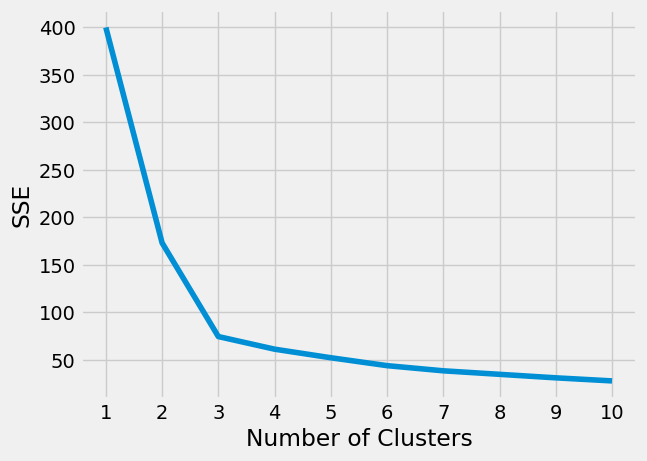

In [21]:
plt.style.use('fivethirtyeight')
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [22]:
k1 = KneeLocator(
    range(1,11), sse, curve = "convex", direction="decreasing"
)

In [23]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2,11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  score = silhouette_score(scaled_features, kmeans.labels_)
  silhouette_coefficients.append(score)

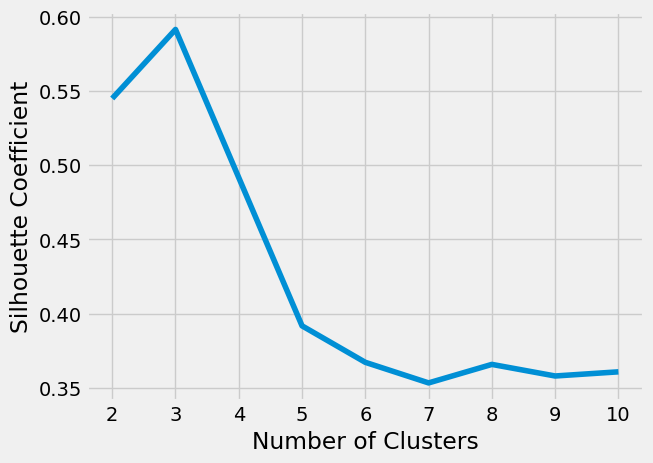

In [24]:
plt.style.use("fivethirtyeight")
plt.plot(range(2,11), silhouette_coefficients)
plt.xticks(range(2,11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#**3.6 Support Vector Machine**
Support-vector machines (SVMs) are supervised learning models in machine learning, which aim to analyze data for classification and regression analysis. Given a set of training examples, each marked as belonging to one of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other. The objective of the support bector machine algorithm is to find a hyperplane in a high dimensional space of the number of features that distinctly classifies the data points. An SVM maps training examples to points in space so as to maximize the width of the gap between the two categories. Predictions of new data are based on which side of the gap they fall.

In [25]:
import numpy as np
import cvxopt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

In [26]:
class SVM:
  def fit(self, X, y):
        n_samples, n_features = X.shape
# P = X^T X
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j])
        P = cvxopt.matrix(np.outer(y, y) * K)
# q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
# A = y^T
        A = cvxopt.matrix(y, (1, n_samples))
# b = 0
        b = cvxopt.matrix(0.0)
# -1 (NxN)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
# 0 (1xN)
        h = cvxopt.matrix(np.zeros(n_samples))
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
# Lagrange multipliers
        a = np.ravel(solution['x'])
# Lagrange have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
# Intercept
        self.b = 0
        for n in range(len(self.a)):
          self.b += self.sv_y[n]
          self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
          self.b /= len(self.a)
# Weights
        self.w = np.zeros(n_features)
        for n in range(len(self.a)):
          self.w += self.a[n] * self.sv_y[n] * self.sv[n]

  def project(self, X):
      return np.dot(X, self.w) + self.b


  def predict(self, X):
      return np.sign(self.project(X))

In [27]:
X, y = make_blobs(n_samples=250, centers=2,
                  random_state=0, cluster_std=0.60)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

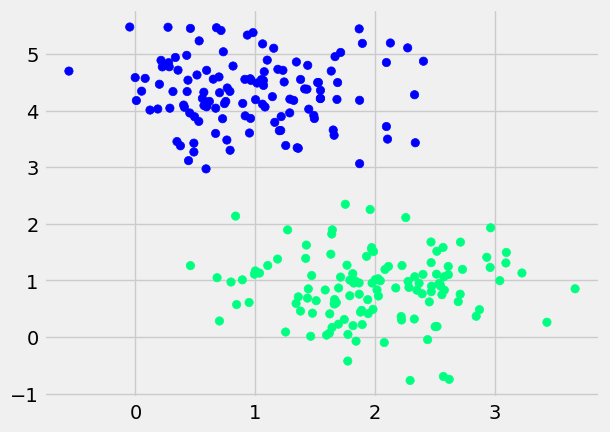

In [28]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='winter')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [30]:
svm = SVM()
svm.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -1.8226e+01 -3.4458e+01  6e+02  2e+01  2e+00
 1: -2.5252e+01 -1.8773e+01  2e+02  9e+00  7e-01
 2: -5.3459e+01 -3.2711e+01  2e+02  7e+00  6e-01
 3: -7.8360e+01 -2.6482e+01  1e+02  4e+00  3e-01
 4: -5.6818e+00 -5.1750e+00  1e+01  2e-01  1e-02
 5: -3.6906e+00 -4.1082e+00  4e-01  4e-16  1e-14
 6: -4.0061e+00 -4.0104e+00  4e-03  9e-16  5e-15
 7: -4.0094e+00 -4.0094e+00  4e-05  6e-16  6e-15
 8: -4.0094e+00 -4.0094e+00  4e-07  2e-15  5e-15
Optimal solution found.


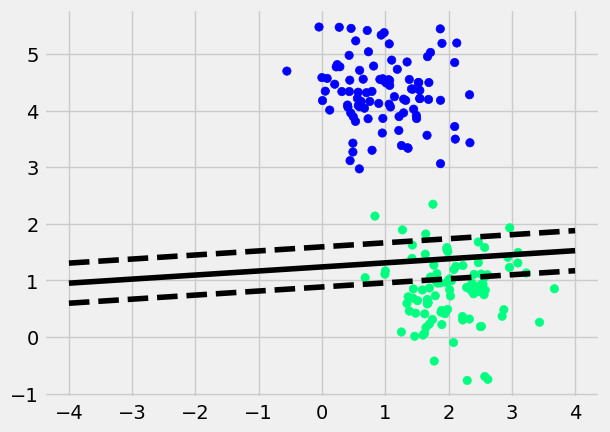

In [31]:
def f(x, w, b, c=0):
  return (-w[0] * x - b + c) / w[1]
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='winter')
# w.x + b = 0
a0 = -4; a1 = f(a0, svm.w, svm.b)
b0 = 4; b1 = f(b0, svm.w, svm.b)
plt.plot([a0,b0], [a1,b1], 'k')
# w.x + b = 1
a0 = -4; a1 = f(a0, svm.w, svm.b, 1)
b0 = 4; b1 = f(b0, svm.w, svm.b, 1)
plt.plot([a0, b0], [a1,b1], 'k--')
# w.x + b = -1
a0 = -4; a1 = f(a0, svm.w, svm.b, -1)
b0 = 4; b1 = f(b0, svm.w, svm.b, -1)
plt.plot([a0,b0], [a1,b1], 'k--')

In [32]:
y_pred = svm.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 7, 27]])

In [33]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

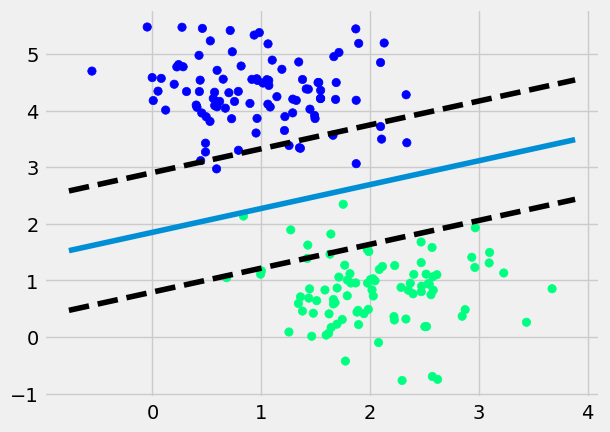

In [36]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='winter');
ax = plt.gca()
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0]/w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (svc.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (svc.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')

In [37]:
y_pred = svc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 0, 34]])